In [1]:
import pandas as pd
import numpy as np
import cv2
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import load_model
from keras.applications.xception import Xception

Using TensorFlow backend.


In [8]:
model = Xception(input_shape=(299, 299, 3))

In [ ]:
model.summary()

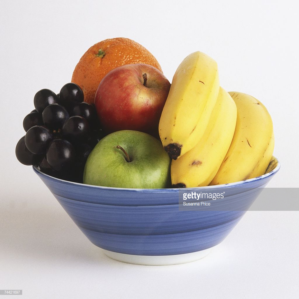

In [4]:
x = img_to_array(load_img('fruits_bowl.jpg', target_size=(299,299)))
array_to_img(x)

In [5]:
# 前処理
X = np.expand_dims(x, axis=0)
X = X.astype('float32')
preprocessed_input = X / 255.0

In [9]:
# dropoutがあるときは、これが必要
K.set_learning_phase(0)

In [10]:
# 予測クラスの算出

predictions = model.predict(preprocessed_input)
class_idx = np.argmax(predictions[0])
class_output = model.output[:, class_idx]

In [11]:
class_idx

954

In [12]:
#  勾配を取得
layer_name = 'block14_sepconv2'
conv_output = model.get_layer(layer_name).output   # layer_nameのレイヤーのアウトプット
grads = K.gradients(class_output, conv_output)[0]  # gradients(loss, variables) で、variablesのlossに関しての勾配を返す
gradient_function = K.function([model.input], [conv_output, grads])  # model.inputを入力すると、conv_outputとgradsを出力する関数

In [13]:
output, grads_val = gradient_function([preprocessed_input])
output, grads_val = output[0], grads_val[0]

In [14]:
# 重みを平均化して、レイヤーのアウトプットに乗じる
weights = np.mean(grads_val, axis=(0, 1))
cam = np.dot(output, weights)

In [15]:
array_to_img(cam[:, :, np.newaxis])

In [16]:
# 画像化してヒートマップにして合成

cam = cv2.resize(cam, (299, 299), cv2.INTER_LINEAR) # 画像サイズは299で処理したので
cam = np.maximum(cam, 0) # 負の値を0にする
cam = cam / cam.max()

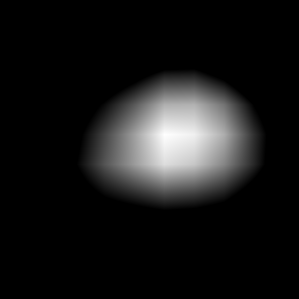

In [17]:
array_to_img(cam[:, :, np.newaxis])

In [18]:
jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
jetcam = (np.float32(jetcam) + x / 2)   # もとの画像に合成

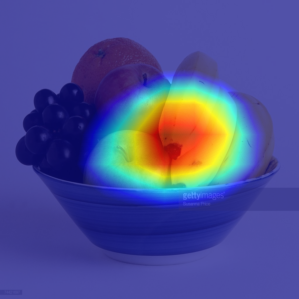

In [19]:
array_to_img(jetcam)

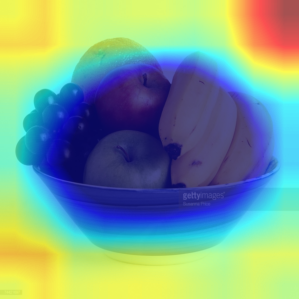

In [28]:
class_idx = 900
class_output = model.output[:, class_idx]
#  勾配を取得
layer_name = 'block14_sepconv2'
conv_output = model.get_layer(layer_name).output  
grads = K.gradients(class_output, conv_output)[0]  
gradient_function = K.function([model.input], [conv_output, grads])  
output, grads_val = gradient_function([preprocessed_input])
output, grads_val = output[0], grads_val[0]
weights = np.mean(grads_val, axis=(0, 1))
cam = np.dot(output, weights)
cam = cv2.resize(cam, (299, 299), cv2.INTER_LINEAR) 
cam = np.maximum(cam, 0) 
cam = cam / cam.max()
jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET) 
jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  
jetcam = (np.float32(jetcam) + x / 2)
array_to_img(jetcam)

## class_idが954(banana)以外は、中心が無視される特徴マップが多そう